# Predykcja cen akcji spółki Microsoft z wykorzystaniem LSTM (ang. Long Short-Term Memory)

## Niezbędne biblioteki

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from keras.api.models import Sequential
from keras.api.layers import *
from keras.api.optimizers import *
from keras.api.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import math
import datetime as dt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from math import ceil
import os

In [2]:
import tensorflow as tf

# Enable eager execution
tf.data.experimental.enable_debug_mode()

In [3]:
tf.executing_eagerly()

True

## Zbieranie danych
 * Zakres dat: od `01-01-2010` do `01-01-2024`
 * Oznaczenie spółki: `MSFT.US`

In [26]:
# Ścieżka do pliku CSV w repozytorium
csv_path = './msft_us_historical_data.csv'

# Sprawdzenie, czy plik istnieje
if not os.path.exists(csv_path):
    # URL do pobrania danych historycznych dla MSFT.US
    url = 'https://stooq.com/q/d/l/?s=msft.us&i=d&d1=20100101&d2=20240101'
    
    # Pobieranie danych
    response = requests.get(url)
    
    # Sprawdzenie, czy żądanie się powiodło
    if response.status_code == 200:
        # Zapisanie danych do pliku CSV w repozytorium
        with open(csv_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Dane zostały pobrane i zapisane do {csv_path}')
    else:
        print(f'Błąd podczas pobierania danych: {response.status_code}')
else:
    print(f'Plik {csv_path} już istnieje')

# Wczytanie danych do DataFrame
df = pd.read_csv(csv_path)

# Wyświetlenie pierwszych kilku wierszy
print(df.head())

# Wyświetlenie podstawowych informacji o danych
print(df.info())

# Zmiana typu kolumny 'Date' na typ daty
df['Date'] = pd.to_datetime(df['Date'])

Plik ./msft_us_historical_data.csv już istnieje
         Date     Open     High      Low    Close        Volume
0  2010-01-04  24.0854  24.4389  24.0358  24.3178  4.886916e+07
1  2010-01-05  24.2542  24.4389  24.0765  24.3267  6.331174e+07
2  2010-01-06  24.2642  24.4230  23.9852  24.1758  7.403254e+07
3  2010-01-07  24.0537  24.1232  23.7221  23.9257  6.434577e+07
4  2010-01-08  23.7837  24.2642  23.7608  24.0934  6.515561e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3522 non-null   object 
 1   Open    3522 non-null   float64
 2   High    3522 non-null   float64
 3   Low     3522 non-null   float64
 4   Close   3522 non-null   float64
 5   Volume  3522 non-null   float64
dtypes: float64(5), object(1)
memory usage: 165.2+ KB
None


## Przygotowanie danych

In [27]:
# Wybór kolumny 'Close' do predykcji
data = df['Close'].values.reshape(-1, 1)

# Normalizacja danych
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Tworzenie sekwencji danych
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Podział na zbiór treningowy i testowy
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y_temp = data[split + seq_length:]

## Funkcja do budowy i trenowania modelu

In [68]:
def build_and_train_model(layers=3, neurons=20, optimizer_class=Adam, optimizer_params={'learning_rate': 0.001}, activation='linear', epochs=50, batch_size=16):
    # Tworzenie modelu sekwencyjnego
    model = Sequential()

    # Dodawanie warstw LSTM
    for i in range(layers):
        if i == 0:
            # Pierwsza warstwa LSTM z określonymi neuronami i kształtem wejściowym
            model.add(Input(shape=(seq_length, 1)))
        elif i == layers - 1:
            # Ostatnia warstwa LSTM bez zwracania sekwencji
            model.add(LSTM(neurons))
        else:
            # Środkowe warstwy LSTM zwracające sekwencje
            model.add(LSTM(neurons, return_sequences=True))
    # Dodawanie warstwy wyjściowej Dense        
    model.add(Dense(1, activation=activation))
    
    # Kompilacja modelu z określonym optymalizatorem i funkcją straty
    optimizer = optimizer_class(**optimizer_params)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Trenowanie modelu na danych treningowych z walidacją na danych testowych
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
    # Zwracanie wytrenowanego modelu i historii trenowania
    return model, history

## Funkcja do rysowania wykresów

In [69]:
def plot_results(df, data, test_data, predicted_data, title, history, file_name, folder_name):
    # Tworzenie folderu, jeśli nie istnieje
    folder_name = 'plots/' + folder_name
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Tworzenie wykresu z trzema podwykresami
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15))

    # Wykres podstawowego zbioru danych do momentu prognozowania
    ax1.plot(df['Date'][:split + seq_length], data[:split + seq_length], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(df['Date'], predicted_data, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title(f'Prognozowanie cen akcji MSFT.US - {title}')
    ax1.legend()
    ax1.grid(True)

    # Wykres przybliżenia okresu testowego i prognoz
    ax2.plot(df['Date'][split + seq_length:], test_data, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(df['Date'][split + seq_length:], predicted_data[split + seq_length:], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    # Wykres błędów trenowania i walidacji
    ax3.plot(history.history['loss'], label='Błąd trenowania')
    ax3.plot(history.history['val_loss'], label='Błąd walidacji')
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel('Błąd')
    ax3.set_title('Błąd trenowania i walidacji')
    ax3.legend()
    ax3.grid(True)

    # Zapisywanie wykresu do pliku
    plot_path = os.path.join(folder_name, f'{file_name}.png')
    plt.savefig(plot_path)
    plt.close(fig)

## Określenie parametrów do testów

### Parametry do przetestowania

In [44]:
layers_options = [2, 3, 4, 5]
neurons_options = [50, 100, 150, 200]
optimizers_options = [Adam, RMSprop, SGD, Adagrad]
activations_options = ['tanh', 'sigmoid', 'linear', 'relu']
batch_sizes = [16, 32, 64, 128]

# Przechowywanie wyników
results = []

# Liczba powtórzeń dla każdego zestawu parametrów
num_repeats = 5

### Testowanie wpływu liczby warstw

In [10]:
for layers in layers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_layers, history_layers = build_and_train_model(layers=layers, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_layers = history_layers.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_layers = model_layers.predict(X_test)
        predicted_layers = scaler.inverse_transform(predicted_layers.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_layers = np.sqrt(mean_squared_error(y_temp, predicted_layers))
        r2_layers = r2_score(y_temp, predicted_layers)

        results.append(('layers', layers, loss_layers, rmse_layers, r2_layers))

        # Przygotowanie danych do wykresu
        predicted_data_layers = np.empty_like(data)
        predicted_data_layers[:, :] = np.nan
        predicted_data_layers[split + seq_length:] = predicted_layers
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_layers, f'Liczba warstw: {layers}', history_layers, f'layers_{layers}_rep_{i}', 'layers')

with pd.ExcelWriter('results.xlsx') as writer:
    df = pd.DataFrame(results, columns=['param', 'value', 'loss', 'rmse', 'R2'])
    df.to_excel(writer, index=False)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


### Testowanie wpływu liczby neuronów

In [42]:
results.clear()

for neurons in neurons_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_neurons, history_neurons = build_and_train_model(neurons=neurons, optimizer_class=RMSprop, optimizer_params=optimizer_params)
        loss_neurons = history_neurons.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_neurons = model_neurons.predict(X_test)
        predicted_neurons = scaler.inverse_transform(predicted_neurons.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_neurons = np.sqrt(mean_squared_error(y_temp, predicted_neurons))
        r2_neurons = r2_score(y_temp, predicted_neurons)
        results.append(('neurons', neurons, loss_neurons, rmse_neurons, r2_neurons))
        
        # Przygotowanie danych do wykresu
        predicted_data_neurons = np.empty_like(data)
        predicted_data_neurons[:, :] = np.nan
        predicted_data_neurons[split + seq_length:] = predicted_neurons
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_neurons, f'Liczba neuronów: {neurons}_{i}', history_neurons, f'neurons_{neurons}_rep_{i}', 'neurons')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='neurons', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


### Testowanie wpływu optymalizatora

In [43]:
results.clear()

for optimizer in optimizers_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_optimizer, history_optimizer = build_and_train_model(optimizer_class=optimizer, optimizer_params=optimizer_params)
        loss_optimizer = history_optimizer.history['val_loss'][-1]
        
        # Predykcja na zbiorze testowym
        predicted_optimizer = model_optimizer.predict(X_test)
        predicted_optimizer = scaler.inverse_transform(predicted_optimizer.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_optimizer = np.sqrt(mean_squared_error(y_temp, predicted_optimizer))   
        r2_optimizer = r2_score(y_temp, predicted_optimizer)
        results.append(('optimizer', optimizer.__name__, loss_optimizer, rmse_optimizer, r2_optimizer))

        # Przygotowanie danych do wykresu
        predicted_data_optimizer = np.empty_like(data)
        predicted_data_optimizer[:, :] = np.nan
        predicted_data_optimizer[split + seq_length:] = predicted_optimizer
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_optimizer, f'Optymalizator: {optimizer.__name__}_{i}', history_optimizer, f'optimizer_{optimizer.__name__}_rep_{i}', 'optimizer')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='optimizer', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


### Testowanie wpływu funkcji aktywacji

In [44]:
results.clear()

for activation in activations_options:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_activation, history_activation = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, activation=activation)
        loss_activation = history_activation.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_activation = model_activation.predict(X_test)
        predicted_activation = scaler.inverse_transform(predicted_activation.reshape(-1, 1))
        
        # Oblicz RMSE i R²
        rmse_activation = np.sqrt(mean_squared_error(y_temp, predicted_activation))
        r2_activation = r2_score(y_temp, predicted_activation)
        results.append(('activation', activation, loss_activation, rmse_activation, r2_activation))

        # Przygotowanie danych do wykresu
        predicted_data_activation = np.empty_like(data)
        predicted_data_activation[:, :] = np.nan
        predicted_data_activation[split + seq_length:] = predicted_activation
        
        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_activation, f'Funkcja aktywacji: {activation}_{i}', history_activation, f'activation_{activation}_rep_{i}', 'activation')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='activation', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


### Testowanie wpływu wielkości batch size

In [45]:
results.clear()

for batch_size in batch_sizes:
    for i in range(num_repeats):
        K.clear_session()
        
        optimizer_params = {'learning_rate': 0.001}
        model_batch_size, history_batch_size = build_and_train_model(optimizer_class=RMSprop, optimizer_params=optimizer_params, batch_size=batch_size)
        loss_batch_size = history_batch_size.history['val_loss'][-1]

        # Predykcja na zbiorze testowym
        predicted_batch_size = model_batch_size.predict(X_test)
        predicted_batch_size = scaler.inverse_transform(predicted_batch_size.reshape(-1, 1))

        # Oblicz RMSE i R²
        rmse_batch_size = np.sqrt(mean_squared_error(y_temp, predicted_batch_size))
        r2_batch_size = r2_score(y_temp, predicted_batch_size)
        results.append(('batch_size', batch_size, loss_batch_size, rmse_batch_size, r2_batch_size))

        # Przygotowanie danych do wykresu
        predicted_data_batch_size = np.empty_like(data)
        predicted_data_batch_size[:, :] = np.nan
        predicted_data_batch_size[split + seq_length:] = predicted_batch_size

        # Rysowanie wykresu
        # plot_results(df, data, data[split + seq_length:], predicted_data_batch_size, f'Batch size: {batch_size}_{i}', history_batch_size, f'batch_size_{batch_size}_rep_{i}', 'batch_size')

with pd.ExcelWriter('results.xlsx', engine='openpyxl', mode='a') as writer:
    results_df = pd.DataFrame(results, columns=['Parameter', 'Value', 'Loss', 'RMSE', 'R²'])
    results_df.to_excel(writer, sheet_name='batch_size', index=False)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


## Model regresji liniowej

RMSE: 121.94138154351353


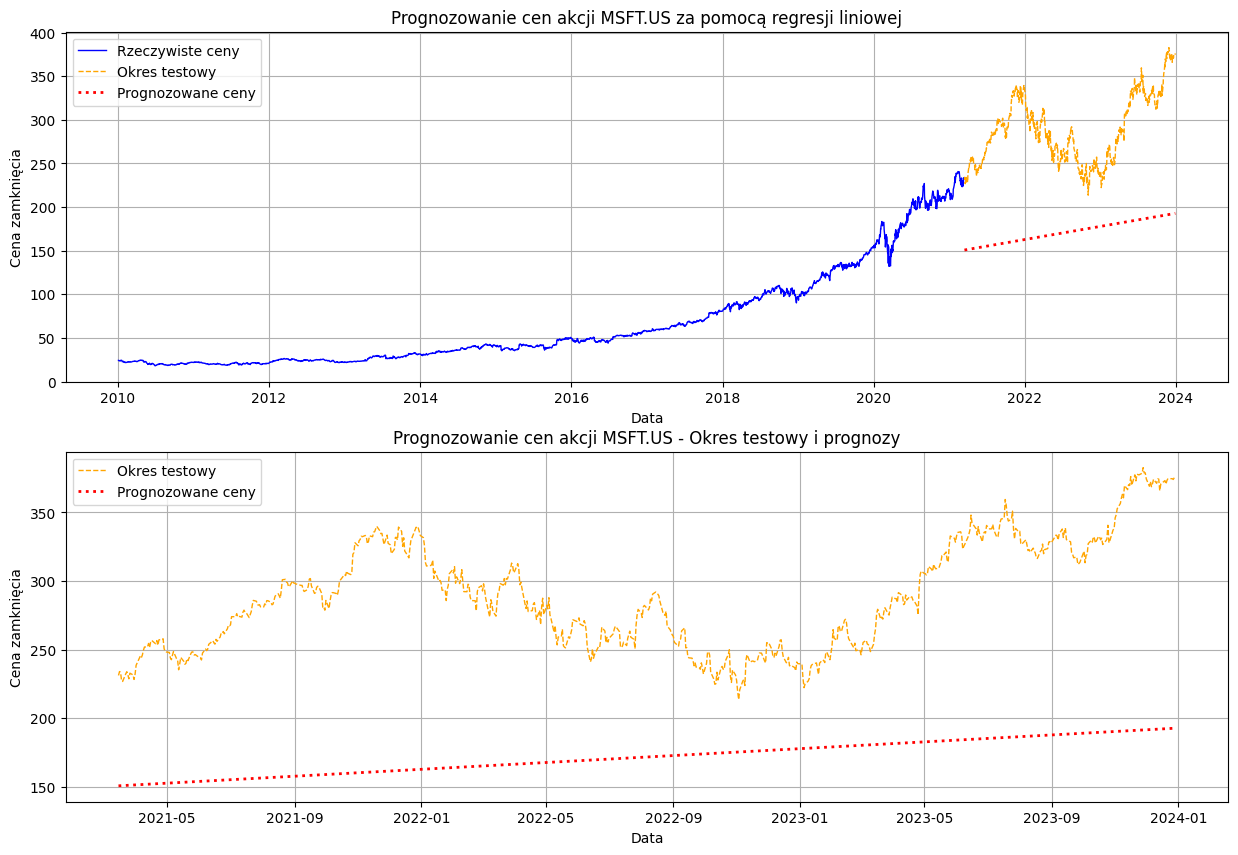

In [39]:
from sklearn.linear_model import LinearRegression

# Przygotowanie danych
df['Date_ordinal'] = df['Date'].map(pd.Timestamp.toordinal)
X = df[['Date_ordinal']]
y = df['Close']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Tworzenie i trenowanie modelu regresji liniowej
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred_lr = model_lr.predict(X_test)

# Obliczanie metryk
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f'RMSE: {rmse_lr}')

# Rysowanie wykresu
# Przygotowanie danych do wykresu
predicted_data_lr = np.empty_like(df['Close'])
predicted_data_lr[:] = np.nan
predicted_data_lr[len(X_train):] = y_pred_lr

# Rysowanie wykresu
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Wykres podstawowego zbioru danych do momentu prognozowania
ax1.plot(df['Date'][:len(X_train)], df['Close'][:len(y_train)], color='blue', label='Rzeczywiste ceny', linewidth=1)
ax1.plot(df['Date'][len(y_train):], y_test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax1.plot(df['Date'][len(X_train):], y_pred_lr, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena zamknięcia')
ax1.set_title('Prognozowanie cen akcji MSFT.US za pomocą regresji liniowej')
ax1.legend()
ax1.grid(True)

# Wykres przybliżenia okresu testowego i prognoz
ax2.plot(df['Date'][len(X_train):], y_test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax2.plot(df['Date'][len(X_train):], y_pred_lr, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax2.set_xlabel('Data')
ax2.set_ylabel('Cena zamknięcia')
ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
ax2.legend()
ax2.grid(True)

plt.savefig('plots/linear_regression.png')
plt.show()

## Model ARIMA

Test RMSE: 4.974
Test R^2: 0.984


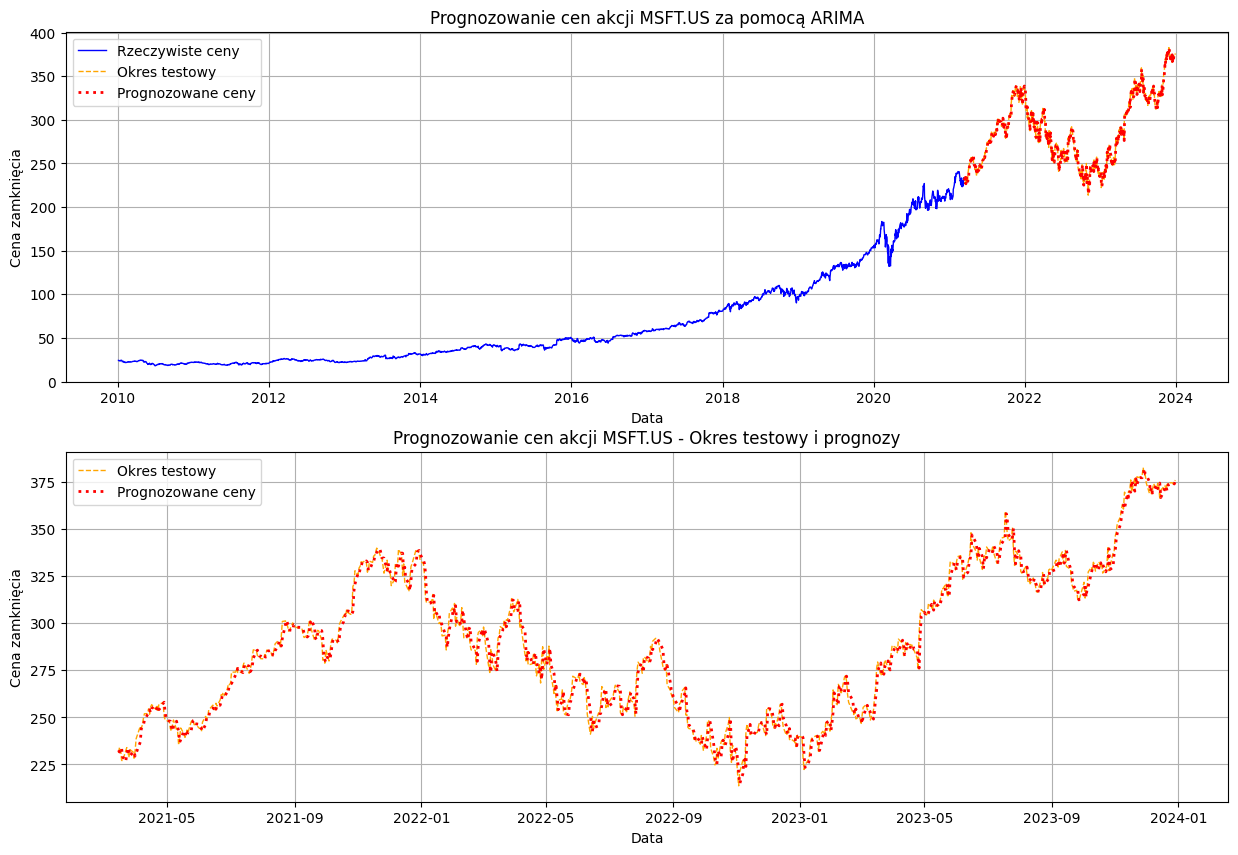

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# === 1. Wczytanie danych ===
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
# df['Close'] = df['Close'].fillna(method='ffill')  # Uzupełnianie braków
df.set_index('Date', inplace=True)  # Ustawienie daty jako indeksu

# === 2. Podział na zbiór treningowy i testowy ===
X = df['Close'].values
train_size = int(len(X) * 0.8)
train, test = X[:train_size], X[train_size:]
history = [x for x in train]
predictions = []

# === 3. Walidacja krocząca (walk-forward validation) ===
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))  # (p=5, d=1, q=0) – można dostosować
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# === 4. Ocena prognozy ===
rmse = sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test, predictions)  
print(f'Test RMSE: {rmse:.3f}')
print(f'Test R^2: {r2:.3f}')

predicted_data_arima = np.empty_like(df['Close'])
predicted_data_arima[:] = np.nan
predicted_data_arima[len(train):] = predictions

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Wykres podstawowego zbioru danych do momentu prognozowania
ax1.plot(df.index[:train_size], train, color='blue', label='Rzeczywiste ceny', linewidth=1)
ax1.plot(df.index[train_size:], test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax1.plot(df.index[train_size:], predictions, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena zamknięcia')
ax1.set_title('Prognozowanie cen akcji MSFT.US za pomocą ARIMA')
ax1.legend()
ax1.grid(True)

# Wykres przybliżenia okresu testowego i prognoz
ax2.plot(df.index[train_size:], test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax2.plot(df.index[train_size:], predictions, color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
ax2.set_xlabel('Data')
ax2.set_ylabel('Cena zamknięcia')
ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
ax2.legend()
ax2.grid(True)

# Zapisanie wykresu do pliku
plt.savefig('arima_forecast.png')
plt.show()

## Średnia ruchoma (MA)

RMSE: 17.7748833632138


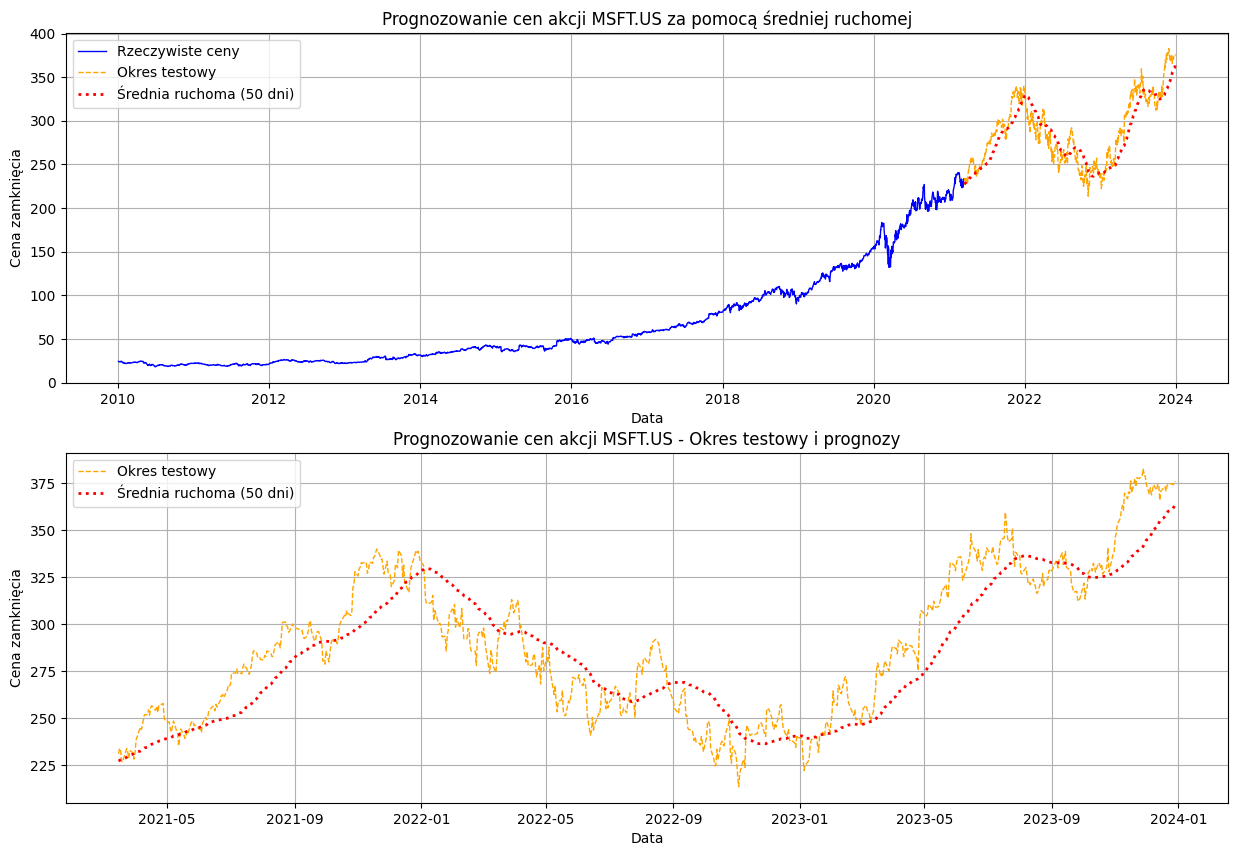

In [91]:
# Określenie okresu dla średniej ruchomej
window_size = 50

# Podział na zbiór treningowy i testowy
X = df[['Date']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Obliczanie średniej ruchomej
df['MA'] = df['Close'].rolling(window=window_size).mean()

# RMSE
rmse_ma = np.sqrt(mean_squared_error(y_test, df['MA'][len(X_train):]))
print(f'RMSE: {rmse_ma}')

# Rysowanie wykresu
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Wykres podstawowego zbioru danych do momentu prognozowania
ax1.plot(df['Date'][:len(X_train)], df['Close'][:len(y_train)], color='blue', label='Rzeczywiste ceny', linewidth=1)
ax1.plot(df['Date'][len(y_train):], y_test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax1.plot(df['Date'][len(X_train):], df['MA'][len(X_train):], color='red', linestyle='dotted', label=f'Średnia ruchoma ({window_size} dni)', linewidth=2)
ax1.set_xlabel('Data')
ax1.set_ylabel('Cena zamknięcia')
ax1.set_title('Prognozowanie cen akcji MSFT.US za pomocą średniej ruchomej')
ax1.legend()
ax1.grid(True)

# Wykres przybliżenia okresu testowego i prognoz
ax2.plot(df['Date'][len(X_train):], y_test, color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
ax2.plot(df['Date'][len(X_train):], df['MA'][len(X_train):], color='red', linestyle='dotted', label=f'Średnia ruchoma ({window_size} dni)', linewidth=2)
ax2.set_xlabel('Data')
ax2.set_ylabel('Cena zamknięcia')
ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
ax2.legend()
ax2.grid(True)

# Zapisywanie wykresu do pliku
plot_dir = './plots'
if not os.path.exists(plot_dir):
	os.makedirs(plot_dir)

plt.savefig(os.path.join(plot_dir, 'moving_average.png'))
plt.show()

## KNN

RMSE: 226.19827637859308


C:\Users\wera6\AppData\Local\Temp\ipykernel_12248\3523002561.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_set['Predictions'] = preds


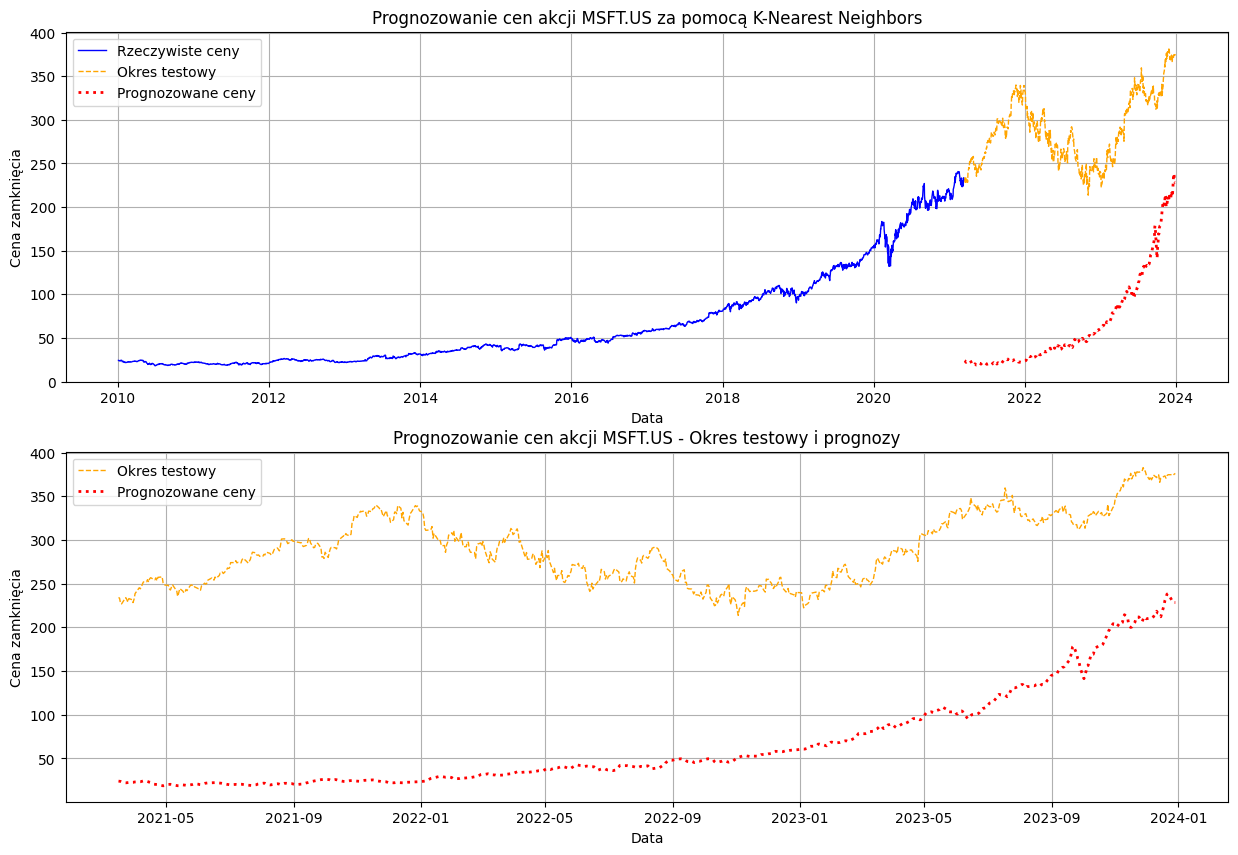

In [99]:
def k_nearest_neighbours_predict(df):
    shape = df.shape[0]
    
    df_new = df[['Date', 'Close']]
    
    train_set = df_new.iloc[:ceil(shape * 0.8)]
    valid_set = df_new.iloc[ceil(shape * 0.8):]
     
    train = train_set.reset_index(drop=True)
    valid = valid_set.reset_index(drop=True)

    # Przekształcenie daty na liczbę (ordinal) do użycia w modelu
    x_train = train['Date'].map(dt.datetime.toordinal)  # Przekształcenie 'Date' na 'ordinal'
    y_train = train[['Close']]
    x_valid = valid['Date'].map(dt.datetime.toordinal)  # Przekształcenie 'Date' na 'ordinal'
    y_valid = valid[['Close']]
    
    # Skalowanie danych
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, 1))
    x_train = pd.DataFrame(x_train_scaled)
    x_valid_scaled = scaler.fit_transform(np.array(x_valid).reshape(-1, 1))
    x_valid = pd.DataFrame(x_valid_scaled)
    
    params = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
    
    # Model KNN z wyszukiwaniem najlepszych parametrów
    knn = KNeighborsRegressor()
    model = GridSearchCV(knn, params, cv=5)
    model.fit(x_train, y_train)
    
    preds = model.predict(x_valid)
    
    # Obliczanie RMSE
    rms = np.sqrt(np.mean(np.power((np.array(y_valid) - np.array(preds)), 2)))
    print('RMSE:', rms)
    
    valid_set['Predictions'] = preds
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.plot(train_set['Date'], train_set['Close'], color='blue', label='Rzeczywiste ceny', linewidth=1)
    ax1.plot(valid_set['Date'], valid_set['Close'], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax1.plot(valid_set['Date'], valid_set['Predictions'], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax1.set_xlabel('Data')
    ax1.set_ylabel('Cena zamknięcia')
    ax1.set_title('Prognozowanie cen akcji MSFT.US za pomocą K-Nearest Neighbors')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(valid_set['Date'], valid_set['Close'], color='orange', linestyle='dashed', label='Okres testowy', linewidth=1)
    ax2.plot(valid_set['Date'], valid_set['Predictions'], color='red', linestyle='dotted', label='Prognozowane ceny', linewidth=2)
    ax2.set_xlabel('Data')
    ax2.set_ylabel('Cena zamknięcia')
    ax2.set_title('Prognozowanie cen akcji MSFT.US - Okres testowy i prognozy')
    ax2.legend()
    ax2.grid(True)

    # Zapisywanie wykresu do pliku
    plot_dir = './plots'
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    plt.savefig(os.path.join(plot_dir, 'knn_stock_prediction.png'))
    plt.show()

k_nearest_neighbours_predict(df)